In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from shortfall.sim import Simulator, SimConfig
from shortfall.miners.repay_proportional import RepayProportionalShortfallMinerState
from shortfall.miners.burn import BurnShortfallMinerState
from shortfall.miners.repay_ratchet import RepayRatchetShortfallMinerState
from shortfall.miners.base import BaseMinerState
from shortfall.network import *
from shortfall.strategy import *
from shortfall.consts import *
import shortfall.gradient.base_cost_models as bcm

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from tqdm.auto import tqdm
from ipywidgets import *

In [3]:
days = 3 * YEAR + 1
stats_interval = DAY

network = dataclasses.replace(MAINNET_APR_2023,
    token_lease_fee=0.20,
    reward_decay=REWARD_DECAY, # or try REWARD_DECAY + BASELINE_GROWTH
    initial_pledge_projection_period_days=20.0,
    supply_lock_target=0.3
)

In [83]:
def get_base_income(power, total_pledge_needed_for_power, pledge_borrowed, borrow_cost_aer_pct=20):
    base_strategy = StrategyConfig.power_limited(power * TIBIBYTE / EXBIBYTE, 3 * YEAR, False)
    base_miner_factory = BaseMinerState.factory(balance=total_pledge_needed_for_power)
    baseline_cfg = SimConfig(
        network=network,
        strategy=base_strategy,
        miner_factory=base_miner_factory,
    )
    base_stats = Simulator(baseline_cfg).run_all(days, stats_interval)

    # apply cost model(s) on top of this
    borrow_cost_aer = borrow_cost_aer_pct/100.
    income_apy_cost = bcm.compute_income_borrow_apy(
        base_stats, 
        pledge_borrowed, 
        #apy=bcm.APY, 
        apy=borrow_cost_aer, 
        sampling_rate_days=1)
    return np.array(income_apy_cost)

def get_burn_stats(miner_balance, max_shortfall_possible, power, shortfall_pct_pow):
    burn_miner_factory = BurnShortfallMinerState.factory(balance=miner_balance, 
                                                         max_shortfall_fraction=max_shortfall_possible,
                                                         shortfall_pct_pow=shortfall_pct_pow)

    burn_pl_cfg = SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(power * TIBIBYTE / EXBIBYTE, days, True),
        miner_factory=burn_miner_factory,
    )
    stats_burn = Simulator(burn_pl_cfg).run_all(days, stats_interval)
    return pd.DataFrame(data=stats_burn)

In [84]:
get_burn_stats(0, 0.5, 100, 0)

,day,power_eib,balance,lease,pledge_locked,available,net_equity,reward_earned,fee_burned,lease_fee_accrued,fee_pending
0,1,0.000095,0.0,0.0,348.03217,-348.03217,0.0,0.000000,0.0,0.0,348.03217
1,2,0.000095,0.0,0.0,348.03217,-348.03217,0.0,1.184255,1.1842546,0.0,346.8479
2,3,0.000095,0.0,0.0,348.03217,-348.03217,0.0,2.368135,2.3681345,0.0,345.66403
3,4,0.000095,0.0,0.0,348.03217,-348.03217,0.0,3.551640,3.5516398,0.0,344.48053
4,5,0.000095,0.0,0.0,348.03217,-348.03217,0.0,4.734771,4.734771,0.0,343.2974
...,...,...,...,...,...,...,...,...,...,...,...
1091,1092,0.000095,744.6943,0.0,348.03217,396.6621,744.6943,1092.726632,348.03223,0.0,0.0
1092,1093,0.000095,745.5327,0.0,348.03217,397.50055,745.5327,1093.565088,348.03223,0.0,0.0
1093,1094,0.000095,746.3709,0.0,348.03217,398.33875,746.3709,1094.403278,348.03223,0.0,0.0
1094,1095,0.000095,747.20886,0.0,348.03217,399.1767,747.20886,1095.241203,348.03223,0.0,0.0


In [85]:
# since we normalize by power, no need to sweep power!
# feel free to double check this by sweeping it anyway
delta = 50
# tibs_vec = [np.arange(delta, 200+delta, delta)]
tibs_vec = [50]

external_borrow_rate_aer_vec = [15, 20, 25, 30, 35]

max_shortfall_possible = 0.5
delta=0.1
shortfall_taken_pct_vec = np.arange(0.2,max_shortfall_possible+delta,delta)
shortfall_pct_pow_vec = np.linspace(0,1,5)
burn_results = {}
base_results = {}
for tibs in tqdm(tibs_vec):
    # compute the balance needed in order to onboard the configured power without taking a shortfall
    
    for shortfall_taken_pct in shortfall_taken_pct_vec:
        shortfall_pct_pow_noop = 0  # confirmed this is a NOOP b/c we are using "fee_pending" along w/ balance=0
        shortfall_amt = get_burn_stats(0, shortfall_taken_pct, tibs, shortfall_pct_pow_noop).iloc[0]['fee_pending']
        full_balance_needed = shortfall_amt + get_burn_stats(0, shortfall_taken_pct, tibs, shortfall_pct_pow_noop).iloc[0]['pledge_locked']
        # simulate borrowing same amount from external lender
        for external_borrow_rate_aer in external_borrow_rate_aer_vec:
            key = '%0.02f,%0.02f,%d' % (tibs, shortfall_taken_pct,external_borrow_rate_aer)
            income_base = get_base_income(tibs, full_balance_needed, shortfall_amt, external_borrow_rate_aer)
            base_results[key] = income_base

        for shortfall_pct_pow in shortfall_pct_pow_vec:
            key = '%0.02f,%0.02f,%0.02f' % (tibs, shortfall_pct_pow, shortfall_taken_pct)
            miner_balance = full_balance_needed*(1-shortfall_taken_pct)
            burn_df = get_burn_stats(miner_balance, shortfall_taken_pct, tibs, shortfall_pct_pow)
            burn_results[key] = burn_df

  0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


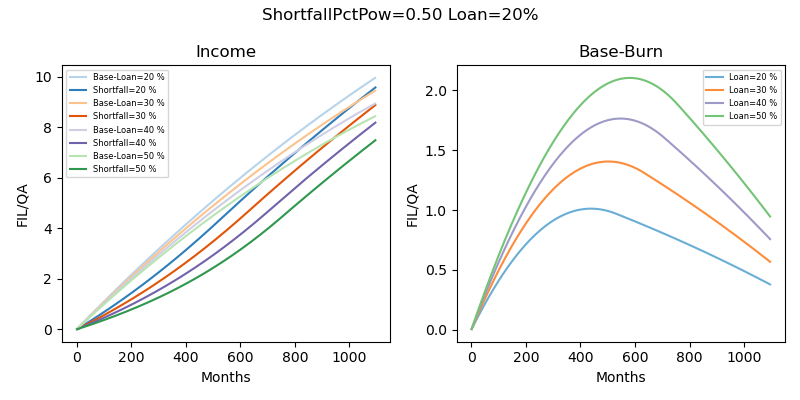

interactive(children=(FloatSlider(value=0.5, description='shortfall_pct_pow', max=1.0, step=0.25), IntSlider(v…

<function __main__.update(shortfall_pct_pow=0.5, external_borrow_rate_aer=20)>

In [92]:
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Purples'], mpl.colormaps['Greens']]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
tibs = tibs_vec[0]
def update(shortfall_pct_pow=0.5, external_borrow_rate_aer=20):
    ax[0].cla()
    ax[1].cla()
    for ii,shortfall_taken_pct in enumerate(shortfall_taken_pct_vec):
        base_key = '%0.02f,%0.02f,%d' % (tibs, shortfall_taken_pct, external_borrow_rate_aer)
        base = base_results[base_key]

        burn_key = '%0.02f,%0.02f,%0.02f' % (tibs, shortfall_pct_pow,shortfall_taken_pct)
        burn_df = burn_results[burn_key]
        
        base_income = base  # rewards - costs
        burn_income = burn_df.iloc[1:]['reward_earned']-burn_df.iloc[1:]['fee_burned']  # rewards - costs
        
        ax[0].plot(base/tibs, color=colors[ii](0.3), label='Base-Loan=%d %%' % (shortfall_taken_pct*100,))
        ax[0].plot(burn_income/tibs, color=colors[ii](0.7), label='Shortfall=%d %%' % (shortfall_taken_pct*100,))
        ax[1].plot((base_income-burn_income)/tibs, color=colors[ii](0.5), label='Loan=%d %%' % (shortfall_taken_pct*100,))
        
    ax[0].legend(fontsize=6)
    ax[0].set_ylabel('FIL/QA')
    ax[0].set_xlabel('Months')
    ax[0].set_title('Income')
    ax[1].legend(fontsize=6)
    ax[1].set_title('Base-Burn')
    ax[1].set_ylabel('FIL/QA')
    ax[1].set_xlabel('Months')

    plt.suptitle('ShortfallPctPow=%0.02f Loan=%d%%' % (shortfall_pct_pow,external_borrow_rate_aer))
    plt.tight_layout()
    fig.canvas.draw_idle()

update()
interact(update, shortfall_pct_pow=(0,1,0.25), external_borrow_rate_aer=(15,35,5))

In [ ]:
"""
Plot on the right is showing the relative gains of external-lending to shortfall. If you take
more shortfall, you are better off using external-lending.  This is a property we want.
"""